Install libraries

In [ ]:
!pip install -q transformers datasets shap scikit-learn pandas matplotlib streamlit torch>=1.13.0 requests


Imports and helper utilities

In [ ]:
import os
import json
import re
import random
from pathlib import Path
from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
import matplotlib.pyplot as plt
import requests
import warnings
warnings.filterwarnings("ignore")


files upload

In [ ]:
from google.colab import files
import pandas as pd, json


In [ ]:
uploaded = files.upload()
with open("MMHS150K_GT.json", "r", encoding="utf-8") as f:
    gt = json.load(f)


rows = []
for tid, meta in gt.items():
    rows.append({
        "tweet_id": str(tid),
        "tweet_text": meta.get("tweet_text",""),
        "labels": meta.get("labels", []),
        "labels_str": meta.get("labels_str", [])
    })
df = pd.DataFrame(rows)
print("GT loaded:", df.shape)
df.head()


Saving MMHS150K_GT.json to MMHS150K_GT.json
GT loaded: (149823, 4)


,tweet_id,tweet_text,labels,labels_str
0,1114679353714016256,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[Religion, Racist, Homophobe]"
1,1063020048816660480,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]","[OtherHate, OtherHate, OtherHate]"
2,1108927368075374593,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]"
3,1114558534635618305,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]"
4,1035252480215592966,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]"


In [ ]:
uploaded = files.upload()
with open("train_ids.txt", "r", encoding="utf-8") as f:
    train_ids = [l.strip() for l in f if l.strip()]
print("Train IDs:", len(train_ids))


Saving train_ids.txt to train_ids.txt
Train IDs: 134823


In [ ]:
uploaded = files.upload()
with open("val_ids.txt", "r", encoding="utf-8") as f:
    val_ids = [l.strip() for l in f if l.strip()]
print("Val IDs:", len(val_ids))


Saving val_ids.txt to val_ids.txt
Val IDs: 5000


In [ ]:
uploaded = files.upload()
with open("test_ids.txt", "r", encoding="utf-8") as f:
    test_ids = [l.strip() for l in f if l.strip()]
print("Test IDs:", len(test_ids))


Saving test_ids.txt to test_ids.txt
Test IDs: 10000


In [ ]:
uploaded = files.upload()
with open("hatespeech_keywords.txt", "r", encoding="utf-8") as f:
    keywords = [l.strip() for l in f if l.strip()]
print("Keywords loaded:", len(keywords))
print(keywords[:20])


Saving hatespeech_keywords.txt to hatespeech_keywords.txt
Keywords loaded: 86
['asian drive', 'feminazi', 'sjw', 'WomenAgainstFeminism', 'blameonenotall', 'islam terrorism', 'notallmen', 'victimcard', 'victim card', 'arab terror', 'gamergate', 'jsil', 'racecard', 'race card', 'refugeesnotwelcome', 'DeportallMuslims', 'banislam', 'banmuslims', 'destroyislam', 'norefugees']


splits file

In [ ]:
def load_split_file(path):
    if not Path(path).exists(): return None
    with open(path, "r", encoding="utf-8") as f:
        return [l.strip() for l in f if l.strip()]

DATA_DIR = "." # Define DATA_DIR
train_ids = load_split_file(Path(DATA_DIR)/"train_ids.txt")
val_ids   = load_split_file(Path(DATA_DIR)/"val_ids.txt")
test_ids  = load_split_file(Path(DATA_DIR)/"test_ids.txt")

# Create binary ground truth label: majority vote of the 3 annotators: 0 => NotHate, any other => Hate
def majority_label(lbls):
    # lbls is a list of ints (0..5). We'll take the modal label; if tie, pick max.
    if not lbls:
        return 0
    vals, counts = np.unique(lbls, return_counts=True)
    return int(vals[np.argmax(counts)])

df["major_label"] = df["labels"].apply(majority_label)
# Convert to binary
df["label"] = (df["major_label"] != 0).astype(int)  # 1 => hate, 0 => not hate

print("Counts by binary label:")
print(df["label"].value_counts())

# If splits exist, filter accordingly
if train_ids and val_ids and test_ids:
    train_df = df[df["tweet_id"].isin(train_ids)].reset_index(drop=True)
    val_df = df[df["tweet_id"].isin(val_ids)].reset_index(drop=True)
    test_df = df[df["tweet_id"].isin(test_ids)].reset_index(drop=True)
    print("Using provided splits:", train_df.shape, val_df.shape, test_df.shape)
else:
    # create stratified split 80/10/10
    stratify_col = df["label"]
    train_df, rest_df = train_test_split(df, test_size=0.2, stratify=stratify_col, random_state=42)
    val_df, test_df = train_test_split(rest_df, test_size=0.5, stratify=rest_df["label"], random_state=42)
    print("Created splits:", train_df.shape, val_df.shape, test_df.shape)

Counts by binary label:
label
0    124003
1     25820
Name: count, dtype: int64
Using provided splits: (134823, 6) (5000, 6) (10000, 6)


Basic cleaning + exact duplicate removal + optional near-duplicates (TF-IDF cos)

In [ ]:

def clean_text(s):
    if not isinstance(s, str): return ""
    s = s.strip()
    s = re.sub(r"http\S+|www\.\S+", " ", s)  # remove URLs
    s = re.sub(r"@\w+", " ", s)               # remove mentions
    s = re.sub(r"#", " ", s)                  # optional: remove #
    s = re.sub(r"\s+", " ", s)
    return s.strip()

for d in (train_df, val_df, test_df):
    d["clean_text"] = d["tweet_text"].fillna("").astype(str).apply(clean_text)

# drop exact duplicates within train (and optionally across)
before = len(train_df)
train_df = train_df.drop_duplicates(subset=["clean_text"]).reset_index(drop=True)
print("Dropped exact duplicates in train:", before - len(train_df))

# Optional near-duplicate removal using TF-IDF + cosine between small batches (safe for small datasets)
REMOVE_NEAR_DUPLICATES = False
if REMOVE_NEAR_DUPLICATES:
    vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X = vec.fit_transform(train_df["clean_text"].values)
    # naive: compute pairwise and drop if cos>0.95 (O(N^2) - careful)
    from sklearn.metrics.pairwise import cosine_similarity
    cos = cosine_similarity(X)
    to_drop = set()
    thresh = 0.95
    n = cos.shape[0]
    for i in range(n):
        for j in range(i+1,n):
            if cos[i,j] > thresh:
                to_drop.add(j)
    if to_drop:
        train_df = train_df.drop(train_df.index[list(to_drop)]).reset_index(drop=True)
        print("Removed", len(to_drop), "near-duplicates")


Dropped exact duplicates in train: 9714


Build final balanced dataset (oversample minority)

In [ ]:
# Cell 7: balancing (simple oversample minority in training set)
TARGET_BALANCE = True
if TARGET_BALANCE:

    counts = train_df["label"].value_counts()
    print("Before balancing:", counts.to_dict())
    max_count = counts.max()
    parts = []
    for lbl in counts.index:
        subset = train_df[train_df["label"] == lbl]
        if len(subset) < max_count:
            up = resample(subset, replace=True, n_samples=max_count, random_state=42)
            parts.append(up)
        else:
            parts.append(subset)
    train_df = pd.concat(parts).sample(frac=1, random_state=42).reset_index(drop=True)
    print("After balancing:", train_df["label"].value_counts().to_dict())


Before balancing: {0: 105975, 1: 19134}
After balancing: {0: 105975, 1: 105975}


Download  English bad-words list and prepare masking

In [ ]:
# Cell 8: get bad-words list (LDNOOBW) + local hatespeech_keywords.txt, prepare mask function
ldnoobw_en_url = "https://raw.githubusercontent.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words/master/en"
try:
    r = requests.get(ldnoobw_en_url, timeout=10)
    repo_badwords = set([w.strip().lower() for w in r.text.splitlines() if w.strip() and not w.startswith("#")])
    print("Fetched LDNOOBW English list items:", len(repo_badwords))
except Exception as e:
    print("Could not fetch LDNOOBW list:", e)
    repo_badwords = set()

local_kw_path = Path(DATA_DIR) / "hatespeech_keywords.txt"
local_bad = set()
if local_kw_path.exists():
    with open(local_kw_path, "r", encoding="utf-8") as f:
        for line in f:
            w=line.strip()
            if w:
                local_bad.add(w.lower())
    print("Loaded local hatespeech_keywords:", len(local_bad))
else:
    print("No local hatespeech_keywords.txt found at", local_kw_path)

# union lists
badwords = set([w for w in repo_badwords if w]) | local_bad
print("Total badwords used for masking:", len(badwords))

# simple token-based masker (keeps punctuation)
def mask_text(text, badwords_set):
    # replace whole-word tokens that match (case-insensitive)
    def repl(m):
        tok = m.group(0)
        if tok.lower() in badwords_set:
            return "*" * len(tok)
        return tok
    return re.sub(r"\b\w+\b", repl, text, flags=re.IGNORECASE)

# quick test
print(mask_text("u r nigga , you @someone! that's crazy", badwords))


Fetched LDNOOBW English list items: 403
Loaded local hatespeech_keywords: 72
Total badwords used for masking: 467
u r ***** , you @someone! that's crazy


Small helper to optionally run on small subset (

In [ ]:

USE_SMALL_SUBSET = True
MAX_TRAIN = 4000
if USE_SMALL_SUBSET:
    print("Using small subset for quick experiments:", MAX_TRAIN)
    train_df = train_df.sample(min(len(train_df), MAX_TRAIN), random_state=42).reset_index(drop=True)
    print("Train shape now:", train_df.shape)


Using small subset for quick experiments: 4000
Train shape now: (4000, 7)


Prepare HuggingFace Datasets and Tokenizer/Model (DistilBERT)

In [ ]:

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def hf_dataset_from_df(df):
    ds = Dataset.from_pandas(df[["tweet_id","clean_text","label"]].rename(columns={"clean_text":"text"}))
    return ds

train_ds = hf_dataset_from_df(train_df)
val_ds = hf_dataset_from_df(val_df)
test_ds = hf_dataset_from_df(test_df)

dataset_dict = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})
print(dataset_dict)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
dataset_tokenized = dataset_dict.map(tokenize_fn, batched=True)
dataset_tokenized = dataset_tokenized.remove_columns(["tweet_id","text"])
dataset_tokenized.set_format("torch")
print("Tokenized datasets:", dataset_tokenized)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'text', 'label'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['tweet_id', 'text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['tweet_id', 'text', 'label'],
        num_rows: 10000
    })
})


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenized datasets: DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["validation"],
    compute_metrics=compute_metrics,
)

trainer.train()

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.739508,0.607400,0.455633,0.681477,0.546127
2,0.619806,0.737055,0.630000,0.475180,0.646278,0.547677
3,0.619806,0.795680,0.643600,0.488305,0.590306,0.534483


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=750, training_loss=0.5630093180338541, metrics={'train_runtime': 224.212, 'train_samples_per_second': 53.521, 'train_steps_per_second': 3.345, 'total_flos': 397402195968000.0, 'train_loss': 0.5630093180338541, 'epoch': 3.0})

In [ ]:
test_results = trainer.evaluate(dataset_tokenized["test"])
print("Test Results:")
print(test_results)

Test Results:
{'eval_loss': 0.7422634959220886, 'eval_accuracy': 0.623, 'eval_precision': 0.4698222405952873, 'eval_recall': 0.6535365152386429, 'eval_f1': 0.5466570466570466, 'eval_runtime': 42.5683, 'eval_samples_per_second': 234.916, 'eval_steps_per_second': 14.682, 'epoch': 3.0}


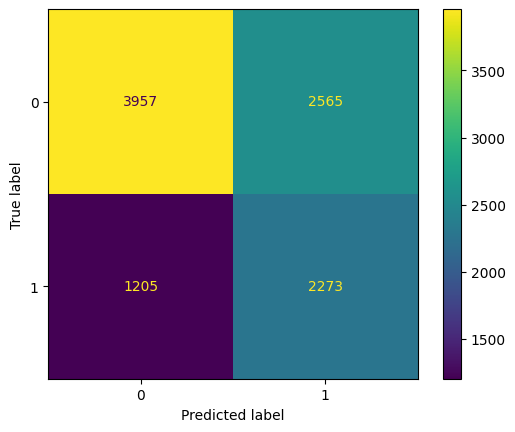

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(dataset_tokenized["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
import shap
import torch
import numpy as np

# Ensure the model is in evaluation mode and on the correct device
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define a prediction function that is robust to the input type from SHAP's masker.
# It seems SHAP's masker might pass a numpy array of strings (for raw/masked text)
# or potentially numerical input_ids/attention_mask.
def predict_proba_for_shap(input_data):
    # Check if the input_data is a numpy array of strings
    if isinstance(input_data, np.ndarray) and input_data.dtype.kind == 'U': # 'U' for Unicode strings
        texts = input_data.tolist() # Convert to list of Python strings
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
    # Check if the input_data is already numerical (e.g., input_ids from a masker)
    elif isinstance(input_data, np.ndarray) and (input_data.dtype == np.int64 or input_data.dtype == np.int32):
        input_ids_tensor = torch.tensor(input_data).to(device)
        # Create attention mask from numerical input_ids if not explicitly provided
        attention_mask_tensor = (input_ids_tensor != tokenizer.pad_token_id).long().to(device)
        inputs = {
            'input_ids': input_ids_tensor,
            'attention_mask': attention_mask_tensor
        }
    # Fallback for other cases (e.g., single string)
    elif isinstance(input_data, str):
        inputs = tokenizer([input_data], padding=True, truncation=True, return_tensors="pt", max_length=128)
    else:
        # If none of the above, raise an error or try a default (e.g., assume it's directly processable by torch.tensor)
        raise ValueError(f"Unexpected input type to predict_proba_for_shap: {type(input_data)}, dtype: {getattr(input_data, 'dtype', 'N/A')}")

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)
    return probabilities.cpu().numpy()

# Initialize a text masker that uses the tokenizer.
# This masker will generate masked versions of the input text (as strings)
# and feed them to the predict_proba_for_shap function.
masker = shap.maskers.Text(tokenizer)

# Initialize explainer with the custom prediction function and the text masker.
# The masker will handle processing raw text into tokenized form *within the predict_proba_for_shap*.
explainer = shap.Explainer(predict_proba_for_shap, masker, output_names=["NotHate", "Hate"])

# Sample texts for explanation, setting random_state for reproducibility
sample_texts = test_df["clean_text"].sample(5, random_state=42).tolist()
shap_values = explainer(sample_texts)

shap.plots.text(shap_values[0])

PartitionExplainer explainer: 6it [00:11,  2.36s/it]                       


In [ ]:
def predict_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    pred = torch.argmax(probs).item()
    confidence = probs[0][pred].item()
    return {
        "prediction": "Hate Speech" if pred == 1 else "Not Hate Speech",
        "confidence": round(confidence, 4)
    }

print(predict_text("I hate you people"))

{'prediction': 'Hate Speech', 'confidence': 0.7437}
